# Hands-On Stochastic Gradient Descent
***

In this notebook we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Important Note**: We're basically going to implement 25% of your next homework assignment.  As such, I won't be posting the solutions to this notebook.  Pay attention and follow along. 

**Semi-Important Note**: There are some helper functions at the bottom of this notebook.  Scroll down and evaluate those before proceeding. 


In [6]:
import numpy as np 
import matplotlib.pylab as plt 
%matplotlib inline

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

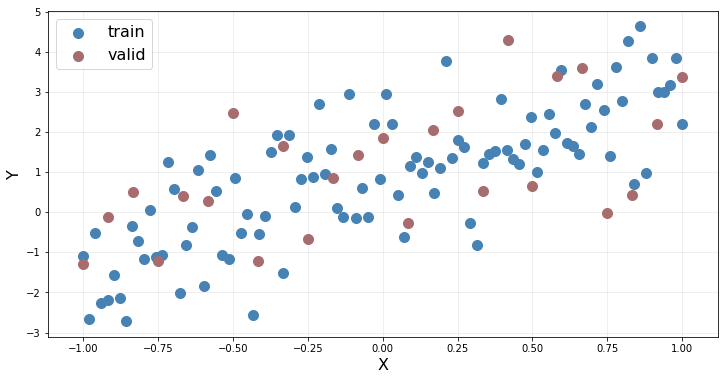

In [7]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1,1,n)
    x_valid = np.linspace(-1,1,int(n/4))
    y_train = 1 + 2*x_train + np.random.randn(n)
    y_valid = 1 + 2*x_valid + np.random.randn(int(n/4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16);

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [8]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

In [9]:
# print(X_train)
print(X_train[:4,1]) # keep from row 1 to 4, but only second column

[-1.         -0.97979798 -0.95959596 -0.93939394]


**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [10]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)
# 0.90918343 is a beta_0, beta_1: 2.20093262
# These two values above are the center of the plotsurface() below

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

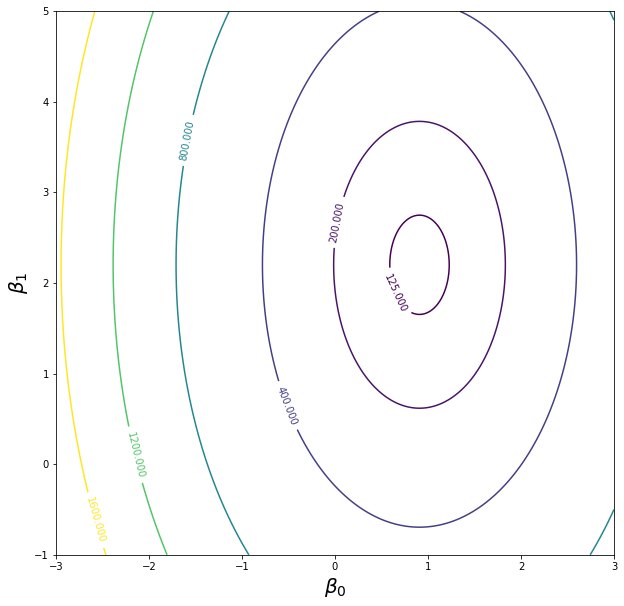

In [11]:
plotsurface(X_train, y_train)

### Part 2: Implementing and Improving SGD 
***


**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes.  

In [ ]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for ee in range(1,num_epochs+1):
        
        # shuffle indices 
#         print("XX: ", X.shape[0])
        shuffled_inds = list(range(X.shape[0]))
        
        np.random.shuffle(shuffled_inds)
        
        
        # loop over training examples 
        for ii in shuffled_inds:
#             muii = (beta[0] + beta[1] * X[ii, 1] - y[ii])
            # beta[o] computer all the time, unnessary
#             beta[0] = beta[0] - eta * 2 * muii  # TODO 
#             beta[1] = beta[1] - eta * 2 * (beta[0] + beta[1] * X[ii, 1] - y[ii]) * X[ii, 1] # TODO 
            
            # Better way to do it
            muii = np.dot(beta, X[ii, :]) - y[ii]
            beta = beta - eta*2 * muii * X[ii,:]

        # save history 
        bhist[ee,:] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

CPU times: user 99.8 ms, sys: 8.9 ms, total: 109 ms
Wall time: 104 ms
beta_0 = 0.90858, beta_1 = 2.20152


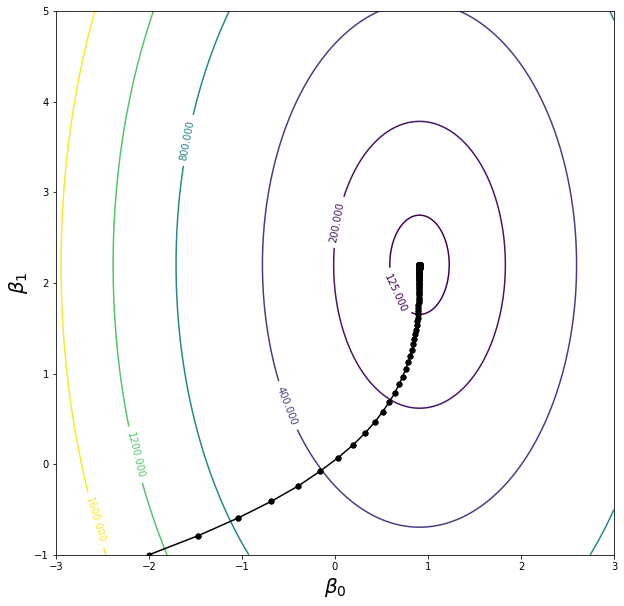

In [18]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.001, num_epochs=200) # old = 0.0025

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Does anything in this computation seem redundant to you?  Think about the case when we have more than two features. When you see it, go back to the `sgd` function and improve it.  


**Part C**: Again, thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 


**Part D**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 


### Part 3: Graphical Diagnosis of Convergence 
***

A common way to monitor the convergence of SGD and to tune hyperparameters (like learning rate and regularization strength) is to make a plot of how the loss function evolves during the training process. That is, we plot the value of the loss function periodically and see if it looks like it's reached a minimum, or see if it's jumping around a lot.  Normally we'd record the value of the loss function as we train, but we'll use the beta histories returned by our solver.  Finally, using the MSE instead of the RSS is a popular choice, so we'll do that.  

**Part A**: Modify the function below to take in a beta history and a data set and return a vector of MSE values for each epoch. 

In [14]:
def MSE_hist(X, y, bhist):
    mse = np.zeros(bhist.shape[0])
#     print(mse)
    for ii in range(bhist.shape[0]):
#         mse[ii] = 0
        mse[ii] = (np.linalg.norm(np.matmul(X, bhist[ii, :]) - y)**2) / len(y)
        
    return mse 


**Part B**: Next we'll take the MSE history that we just computed and plot it vs epoch number. Based on your plot, would you say that your MSE has converged? 

[13.0955502   5.74356899  3.22482166  1.36836906  2.61483815  3.13704617
  1.46286257  5.09521737  1.22190053  3.36754264  1.42160887  8.21440189
  6.14246466  2.47654882  1.22978009  1.50650739  1.55941127  1.37639708
  8.43999158  1.97774051  3.85635483  1.61791459  2.12378267 10.94835397
  1.1838283   4.99143718  2.81714309  3.64198186  2.05466183  1.150117
  2.32712995  2.99121931  1.16805441  5.72256471  2.29455272  1.34620554
  1.19371038  2.45796718  5.09810207  2.79408029  1.76361973  2.01540711
  2.9158844   2.38440388  6.71446613  2.33292511  1.73153126  1.44695471
  3.82145655  1.47586125  5.94856537  2.33355639  1.17982657  1.9142244
  6.8294752   6.86567756  7.29974136  7.34379849  3.06128761  1.68802713
  2.180852    1.20253988  3.18858217  7.13815178  4.88888389 14.65367952
  1.94322716  2.37098807  2.16054197  5.12081965  4.15907259 10.52506941
 15.03515334  2.74001655  8.53002083  7.07931615  1.32683998  1.85170962
  4.62534816  1.80371085  2.19625573  4.71393305  6.30

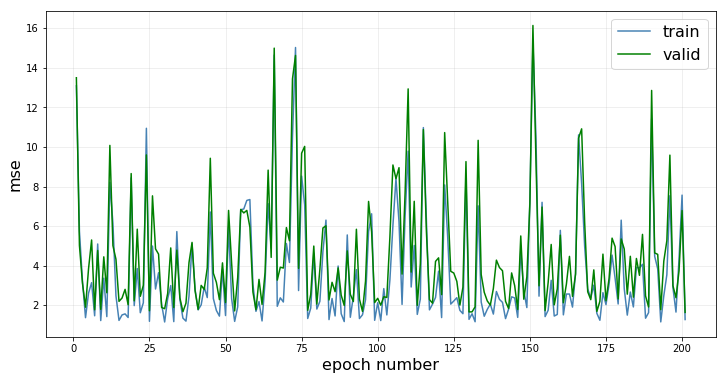

In [15]:
mse_train = MSE_hist(X_train, y_train, bhist)
mse_valid = MSE_hist(X_valid, y_valid, bhist)
# print(mse_train)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.plot(range(1,len(mse_train)+1), mse_valid, color="green", label="valid")

ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

**Part C**: Go back up and change the value of the learning rate to bigger and smaller values (you might also have to adjust the max epochs).  Do the different learning rates have the effect on the MSE plots that you would expect? 

**Part D**: OK, now for the real question.  Is the MSE on the training data the best thing to look at when deciding if our training algorithm has converged? 

### Part 4: The Learning Rate Schedule Game
***

In the case when your negative log-likelihood function is convex, the choice of learning rate mainly affects the convergence of your SGD routine.  In a nonconvex problem, the choice of learning rate can determine whether you find the global minimum, or get stuck forever in a local minimum.  In most sophisticated optimization routines, the learning rate is adapted over time.  Varying learning rate schedules allow you to explore local minimums but still be able to make it out and eventually find the global minimum.  

The following game is a cheap facsimile of stochastic gradient descent.  There is no negative log-likelihood function, or training set.  You just have a simple function that you would like to minimize, namely 

$$
f(x,y) = 5-\sin(3 \pi x) ~ \sin(3 \pi y) - 3~\textrm{exp}\left[{-\left(x-\frac{1}{2}\right)^2 - \left(y-\frac{1}{2}\right)^2}\right]
$$

The surface looks as follows.  Notice that there is a global minimum at $(1/2,1/2)$ and several local maxima and minima surrounding it.

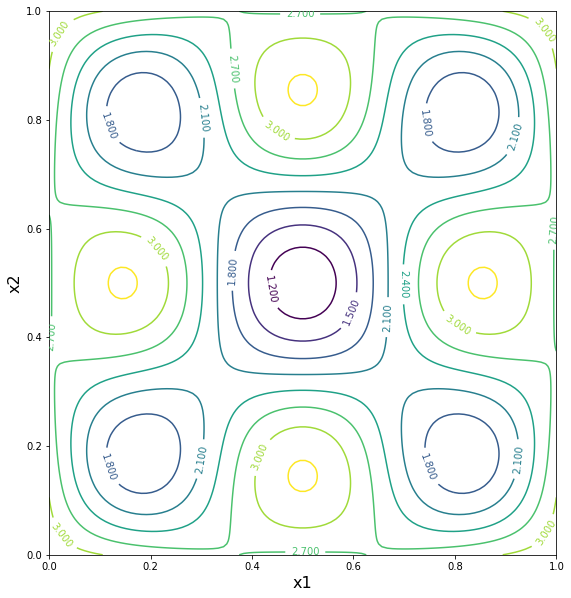

In [23]:
plot_nc_surface()

I've given you a starting point and a basic gradient descent algorithm (located in the Helper Functions section below).  Below this cell there is a learning rate scheduling function that currently just returns the initial learning rate that you prescribe.  The goal of this game is for you to adjust the initial learning rate and the scheduling function that allows the iterate to make it to the global minimum.  The **only** things you're allowed to change are the **initial learning rate** and the **schedule function**.   Before you can play you need to evaluate the code-blocks at the bottom of the page.  Then come back and evaluate the $\texttt{playgame}$ function with it's current inputs and see what happens! 

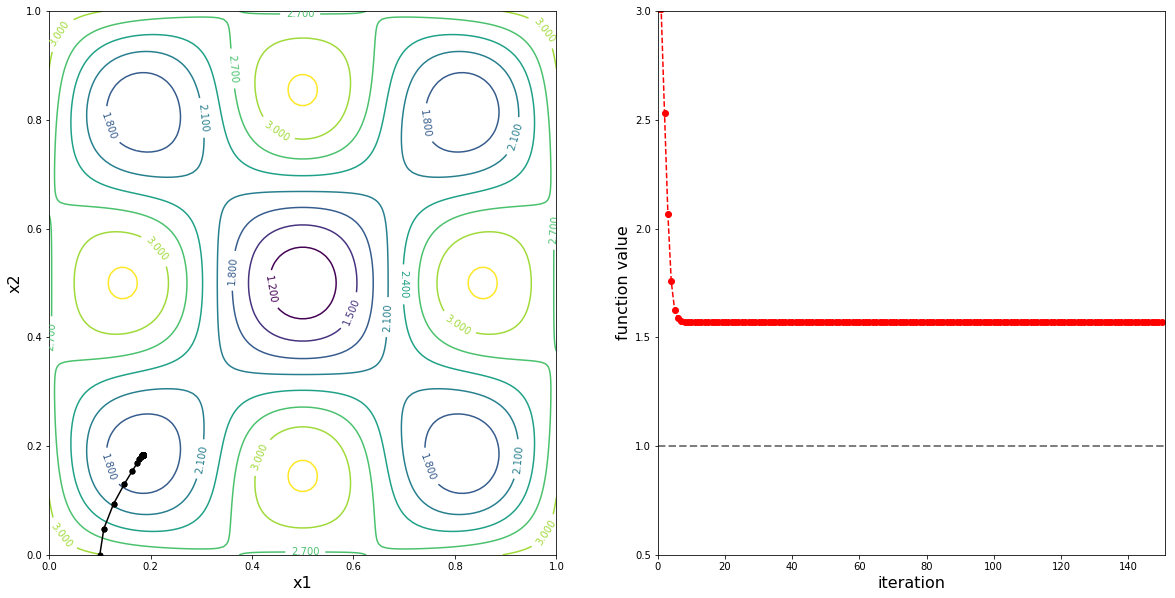

In [32]:

def schedule(K, n, eta0):
    '''
    :param k: The current iteration 
    :param n: The max number of iterations
    :param eta0: The original learning rate 
    '''
    return eta0

playgame(np.array([0.1,0.0]), 150, .005)

***
**Hint**: If you're not having much luck, try implementing a schedule of the form 
$
\eta_k = \dfrac{\eta_0}{ 1 + \alpha ~ k~/~n}
$ where here $\alpha$ is a tuning parameter.  You'll probably also have to make your initial learning rate bigger. 
***

### Helper Functions
***

In [2]:
mycolors = {"blue":"steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke":"#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii,"x"]
        yi = df.loc[ii,"y"]
        rss += (yi - (b0 + b1*xi))**2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1])**2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0,y1], color="black", marker="o", lw=1.5, markersize=5)
            
def myncfun(x, y): 
    return 5 - np.sin(3*np.pi*x)*np.sin(3*np.pi*y) - 3*np.exp(-(x-.5)**2 - (y-.5)**2)

def myncgrad(x):
    g1 = -3 * np.pi * np.cos(3*np.pi*x[0]) * np.sin(3*np.pi*x[1]) + 6 * (x[0]-.5) * np.exp(-(x[0]-.5)**2 - (x[1]-.5)**2)
    g2 = -3 * np.pi * np.sin(3*np.pi*x[0]) * np.cos(3*np.pi*x[1]) + 6 * (x[1]-.5) * np.exp(-(x[0]-.5)**2 - (x[1]-.5)**2)
    return np.array([g1, g2])

def detSGD(x, numstep, eta0):
    '''
    :param x: Starting point 
    :param numstep: Total number iterations 
    :param eta0: Initial learning rate 
    '''
    xhist = np.zeros((numstep+1,2))
    xhist[0,:] = x 
    for kk in range(numstep):
        x = x - schedule(kk, numstep, eta0) * myncgrad(x)
        xhist[kk+1,:] = x 
    return xhist

def playgame(x0, numstep, eta0):
    '''
    :param x0: The starting point 
    :param numstep: The total number of iterations to do 
    :param eta0: The original learning rate 
    '''
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
    Z = myncfun(xx, yy)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    CS = plt.contour(xx, yy, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlim([0,1])
    plt.ylim([0,1])

    xhist = detSGD(x0, numstep, eta0)
    
    fvals = np.zeros(numstep+1)
    fvals[0] = myncfun(x0[0], x0[1])

    for ii in range(xhist.shape[0]-1):
        x0 = xhist[ii][0]
        y0 = xhist[ii][1]
        x1 = xhist[ii+1][0]
        y1 = xhist[ii+1][1]
        ax1.plot([x0, x1], [y0,y1], color="black", marker="o", lw=1.5, markersize=5)
        fvals[ii+1] = myncfun(x0, y0)
        
    plt.xlabel("x1", fontsize=16)
    plt.ylabel("x2", fontsize=16)
        
    maxval = myncfun(0.5,0.5)
        
    ax2 = fig.add_subplot(122)
    ax2.plot(fvals, 'r--', marker="o")
    ax2.plot([0, numstep+1], [maxval, maxval], 'k--', lw=2, alpha=0.5)
    plt.xlim([0,numstep+1])
    plt.ylim([.5,3])
    plt.xlabel("iteration", fontsize=16)
    plt.ylabel("function value", fontsize=16);
    
def plot_nc_surface():
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
    Z = myncfun(xx, yy)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    CS = plt.contour(xx, yy, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("x1", fontsize=16)
    plt.ylabel("x2", fontsize=16)  
    